**Modeling and Evaluation**

### Objectives

* Business requirements 2:
- The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew

### Inputs

* Data from test, train validation folders
* Image shape 

### Outputs

* Images distridution in train, validation and test folders
* Image augmentation
* Model creation
* Model training
* Save model
* Learning curve of the model
* Model Evaluation
 - Accuracy
 - ROC curve
* Confusion Matrix
* Save evaluation
* Check prediction on new file

### Import

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib

### Set working directory

In [63]:
current_dir = os.getcwd()
current_dir

'/workspace/ML5-Mildew-Detection'

In [64]:
os.chdir('/workspace/ML5-Mildew-Detection')
print("You set a new current directory")

You set a new current directory


Double check directory set correctly

In [65]:
working_dir = os.getcwd()
working_dir

'/workspace/ML5-Mildew-Detection'

## Setting input directories

In [66]:
my_data_dir = 'inputs/cherryleaves_data/cherry-leaves'
training_path = my_data_dir + '/train' 
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Setting output directory

In [67]:
version = 'v2_softmax'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

---

## Set labels

In [68]:
labels = os.listdir(training_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


### Image shape

In [69]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

Count number images in each folder

In [70]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




Label Distribution

In [110]:


fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Cherry Leaves Dataset",
            barmode="group",
            text="Label")
fig.update_layout(
    autosize=False,
    width=900, 
    height=600, 
    )
fig.show()
fig.write_image(f'outputs/v1/label_distribution.png')




df_freq_pie = df_freq.groupby('Set')['Count'].sum().reset_index()

fig = go.Figure(data=[go.Pie(
    labels=df_freq_pie['Set'], 
    values=df_freq_pie['Count'],
    hole=0.5,
    marker=dict(colors=['#EF553B', '#636EFA', '#00CC96'])
)])

fig.update_layout(
    title_text='Cherry Leaves Dataset',
    width=800, 
    height=600,
    annotations=[dict(text='Set', x=0.5, y=0.5, font_size=20, showarrow=False)]
)
fig.write_image(f'{file_path}/label_distribution_pie.png')
fig.show()


---

Something to make in unique

## Image data augmentation

import ImageDataGenerator

In [72]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Intiatize ImageDataGenerator


In [73]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Batch size

In [74]:
batch_size = 32

### Augment training image set

In [75]:
train_set = augmented_image_data.flow_from_directory(training_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices
class_names_str = ", ".join(train_set.class_indices)

print(f"Classes: {class_names_str}")

Found 2944 images belonging to 2 classes.
Classes: healthy, powdery_mildew


### Augment Validation Dataset Images

In [76]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices
class_names_str_1 = ", ".join(validation_set.class_indices)
print(f"Classes: {class_names_str_1}")

Found 420 images belonging to 2 classes.
Classes: healthy, powdery_mildew


### Augment Test Dataset Images

In [77]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )

test_set.class_indices
class_names_str_2 = ", ".join(test_set.class_indices)
print(f"Classes: {class_names_str_2}")

Found 844 images belonging to 2 classes.
Classes: healthy, powdery_mildew


### Plot augmented test images

(32, 256, 256, 3)


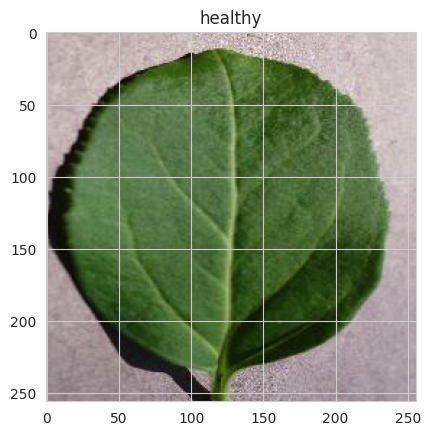

(32, 256, 256, 3)


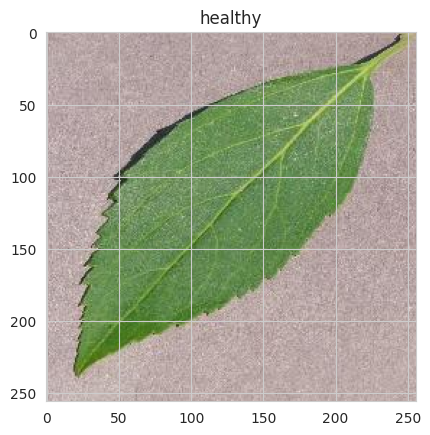

(32, 256, 256, 3)


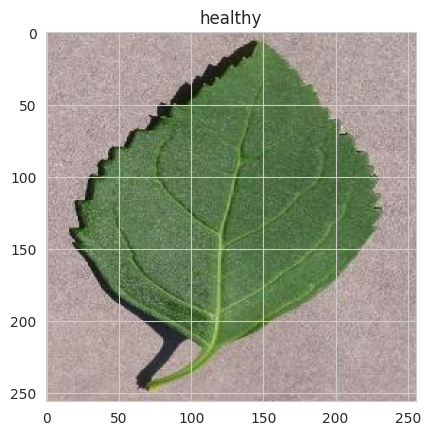

In [78]:
for _ in range(3):
    img, label = test_set.next()
    img_class = list(test_set.class_indices.keys())[np.argmax(label)]
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.title(img_class)
    plt.show()




### Plot augmented training image set

(32, 256, 256, 3)


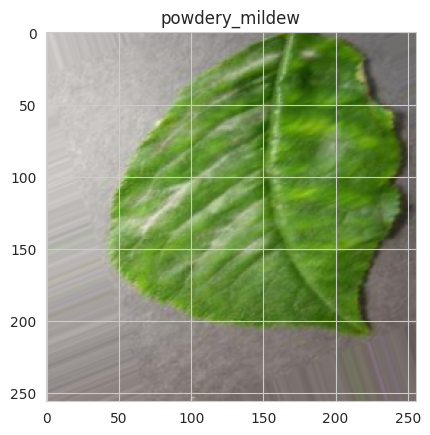

(32, 256, 256, 3)


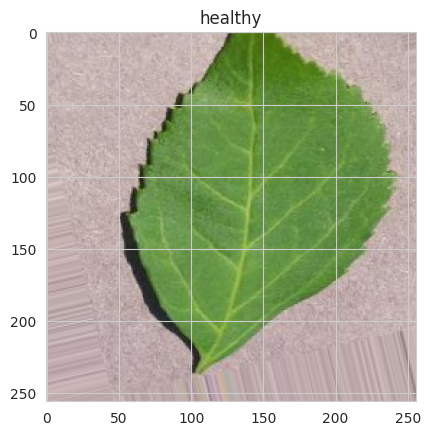

(32, 256, 256, 3)


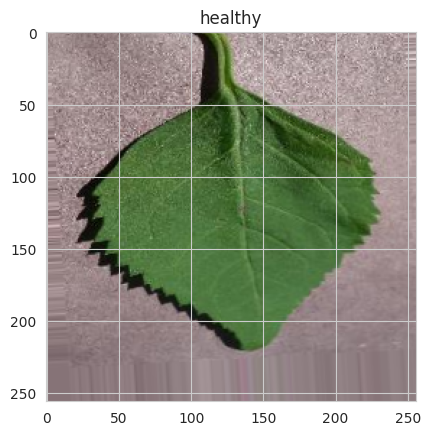

In [79]:
for _ in range(3):
    img, label = train_set.next()
    img_class = list(train_set.class_indices.keys())[np.argmax(label)]
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.title(img_class)
    plt.show()

### Augment validation image set

(32, 256, 256, 3)


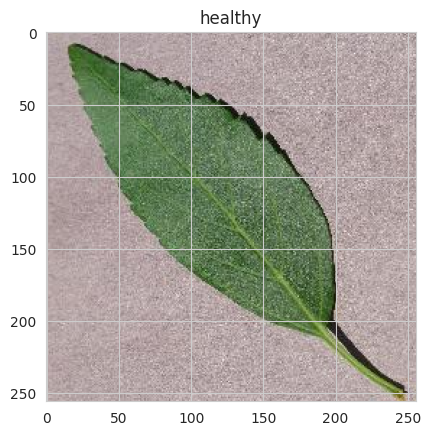

(32, 256, 256, 3)


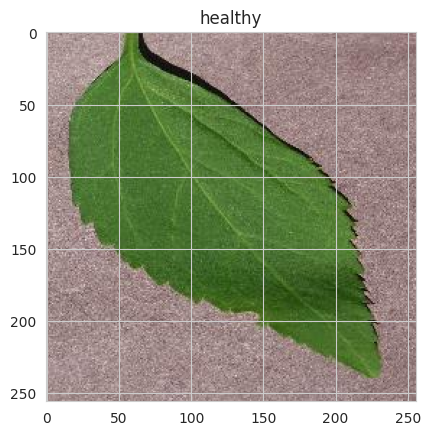

(32, 256, 256, 3)


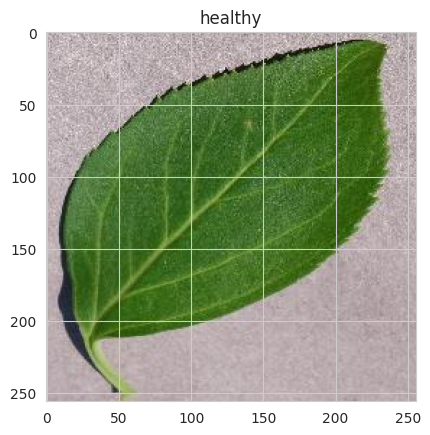

In [80]:
for _ in range(3):
    img, label = validation_set.next()
    img_class = list(validation_set.class_indices.keys())[np.argmax(label)]
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.title(img_class)
    plt.show()

### Save class_indices


In [81]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices_1.pkl")

['outputs/v2_softmax/class_indices_1.pkl']

## Model Creation

### Import model packages

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.activations import swish
from tensorflow.keras.initializers import lecun_normal


## Model

In [83]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))



    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))



    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model



### Model Summary

In [84]:
create_tf_model().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 57600)            

### Early Stopping

In [85]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

### Fit model for training

In [88]:
model = create_tf_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/10
92/92 [==============================] - 224s 2s/step - loss: 0.3305 - accuracy: 0.8390 - val_loss: 0.2084 - val_accuracy: 0.9167
Epoch 2/10
92/92 [==============================] - 288s 3s/step - loss: 0.0697 - accuracy: 0.9793 - val_loss: 0.0126 - val_accuracy: 0.9952
Epoch 3/10
92/92 [==============================] - 223s 2s/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.0185 - val_accuracy: 0.9952
Epoch 4/10
92/92 [==============================] - 242s 3s/step - loss: 0.0794 - accuracy: 0.9772 - val_loss: 0.0047 - val_accuracy: 0.9976
Epoch 5/10
92/92 [==============================] - 216s 2s/step - loss: 0.0262 - accuracy: 0.9912 - val_loss: 0.0205 - val_accuracy: 0.9952
Epoch 6/10
92/92 [==============================] - 198s 2s/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.0432 - val_accuracy: 0.9881
Epoch 7/10
92/92 [==============================] - 192s 2s/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0397 - val_accuracy: 0.9881
Epoch 8/10
92

### Save model

In [89]:
model.save('outputs/v2_softmax/mildew_detection_softmax.h5')

## Model Performance

### Model learining curve

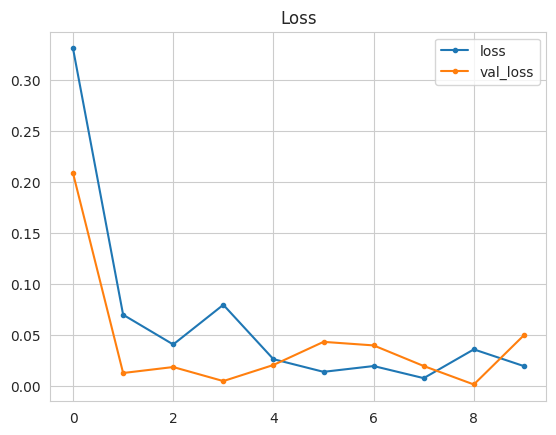

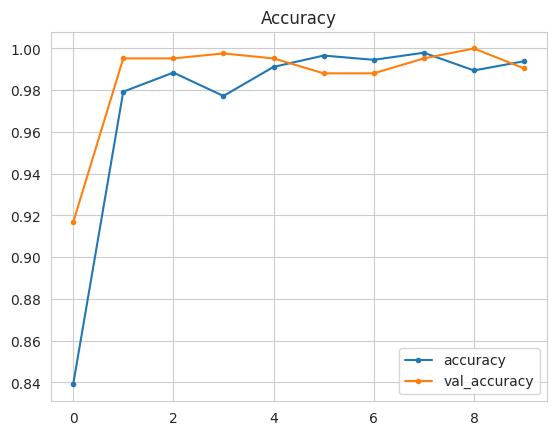

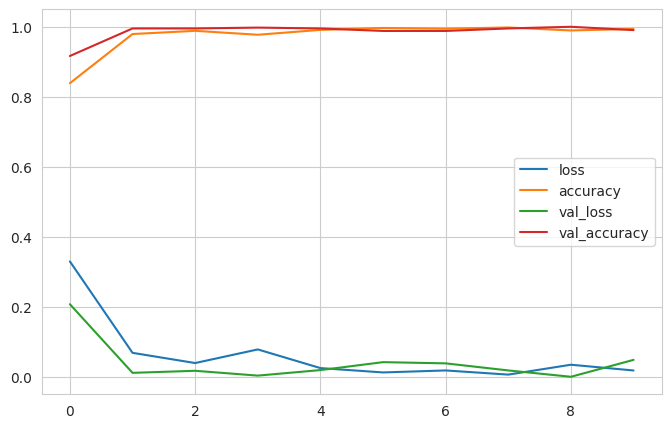

In [90]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()
sns.set_style("whitegrid")
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.show()


In [91]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=model.history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model.history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=model.history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=model.history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy "
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.write_image(f'{file_path}/model_big_plot.png')
fig.show()

Area Under ROC-Curve:  0.9952606635071091


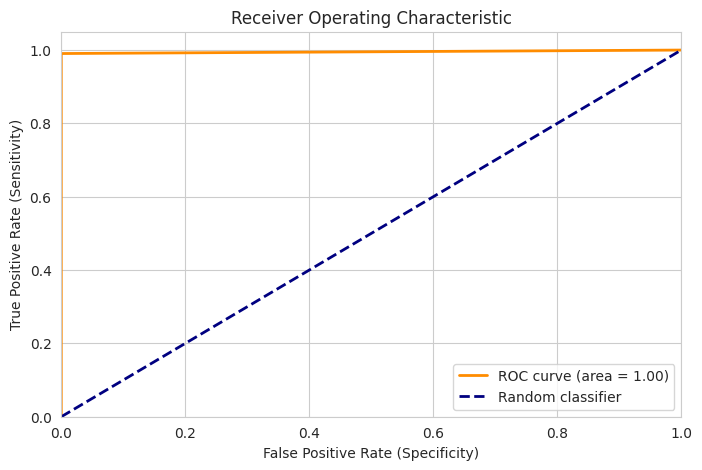

In [92]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)

y_true = test_set.labels
sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

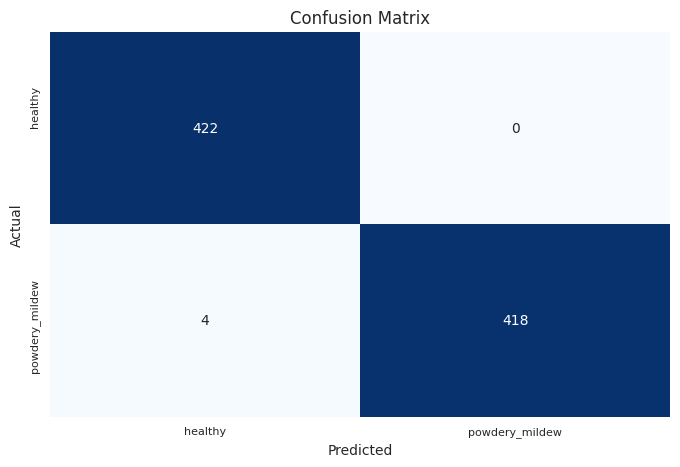

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

In [96]:

print(classification_report(y_true, y_pred, target_names=labels))

                precision    recall  f1-score   support

       healthy       0.99      1.00      1.00       422
powdery_mildew       1.00      0.99      1.00       422

      accuracy                           1.00       844
     macro avg       1.00      1.00      1.00       844
  weighted avg       1.00      1.00      1.00       844



## Model Evaluation

### Load saved model

In [ ]:
from keras.models import load_model
model = load_model('outputs/v2_softmax/mildew_detection_softmax.h5')

### Evaluate model on test set


In [97]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: ",evaluation[1])
print("Model Loss: ",evaluation[0])

27/27 [==============================] - 12s 434ms/step - loss: 0.0213 - accuracy: 0.9953
Model accuracy:  0.9952606558799744
Model Loss:  0.021313099190592766


In [98]:
print(classification_report(y_true, y_pred, target_names=labels))

                precision    recall  f1-score   support

       healthy       0.99      1.00      1.00       422
powdery_mildew       1.00      0.99      1.00       422

      accuracy                           1.00       844
     macro avg       1.00      1.00      1.00       844
  weighted avg       1.00      1.00      1.00       844



### Save evaluation pickle


In [99]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2_softmax/evaluation.pkl")

['outputs/v2_softmax/evaluation.pkl']

## Predict on new data

### Load random image as PIL

Image shape: (256, 256), Image mode: RGB


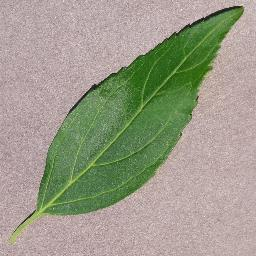

In [100]:
from tensorflow.keras.preprocessing import image

pointer = 40
label = labels[0]  # select healthy or infected leaves

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

### Convert image to array and prepare for prediction

In [101]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict class probabilities

In [102]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1.0
powdery_mildew
